## Read Jarvis CFID data
Read the CFID data in its original `json` format and save to `pkl`.

In [1]:
import os, json
import pandas as pd
import numpy as np
import pickle

f = open('d3-5-16-2021.json', 'r')  # Replace with raw data path
data3d = json.load(f)
f.close()

df = pd.DataFrame(data3d)
df.to_pickle('jarvis_cfid.pkl')

In [3]:
pd.read_pickle('')

(48527, 64)

## Data cleaning

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
data = pd.read_pickle('D:/PSED/Jarvis_cfid/jarvis_cfid.pkl')  # Replace with your path
data_w_modulus = data.copy()

# Remove entries with 0 or N/A moduli
data_w_modulus.drop(data_w_modulus[data_w_modulus['bulk_modulus_kv'] == 'na'].index, inplace=True)
data_w_modulus.drop(data_w_modulus[data_w_modulus['shear_modulus_gv'] == 'na'].index, inplace=True)
data_w_modulus.drop(data_w_modulus[data_w_modulus['bulk_modulus_kv'] <= 0].index, inplace=True)
data_w_modulus.drop(data_w_modulus[data_w_modulus['shear_modulus_gv'] <= 0].index, inplace=True)

In [5]:
data_w_modulus.shape

(18300, 64)

### Graph embeddings
Prepare `id_prop.csv` and `cif` files for CGCNN, get the graph embeddings of materials with modulus

In [ ]:
id_prop = pd.DataFrame(index=data_w_modulus.index)
id_prop['props'] = data_w_modulus.formation_energy_peratom
id_prop.to_csv('id_prop.csv')

from jarvis.core.atoms import Atoms
for ind in data_w_modulus.index:
    Atoms.from_dict(data_w_modulus.atoms[ind]).write_cif('D:/PSED/jarvis_cifs/'+str(ind)+'.cif')

In [19]:
import pandas as pd
cgcnn_features = pd.read_pickle('D:/PSED/Jarvis_cfid/cgcnn_features.pkl')
cgcnn_features.set_index('cif_id', inplace=True)
cgcnn_features.index = cgcnn_features.index.astype('int')
cgcnn_features.index.name = None

cgcnn_features = cgcnn_features.sort_index()
cgcnn_features.to_pickle('cgcnn_features_sorted.pkl')

Down select according to elements of interest or other criteria.

In [7]:
data_downselect = data_w_modulus.copy()
# Remove compounds containing the following elements
for idx in data_downselect.index:
    if not set(data_downselect.atoms[idx]['elements']).isdisjoint({'H', 'F', 'Cl', 'Br', 'I', 'At', 'He', 'Ne', 'Ar', 'Kr', 'Xe', 'Rn',
    'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Tc',
    'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr'}):
        data_downselect.drop(idx, inplace=True)

data_downselect.to_pickle('D:/PSED/Jarvis_cfid/data_cleaned.pkl')

In [9]:
# Obtain the graph embeddings
cgcnn_features = pd.read_pickle('D:/PSED/Jarvis_cfid/cgcnn_features_sorted.pkl')
cgcnn_features.sort_index()
cgcnn_features_down = cgcnn_features.loc[data_downselect.index]

In [2]:
pd.read_pickle('D:/PSED/Jarvis_cfid/data_downselect.pkl').shape

(10898, 64)

## Jarvis data statistics

Calculate relevant statistics of the Jarvis CFID dataset and create visualization plots.

In [3]:
from pymatgen.util.plotting import periodic_table_heatmap, pretty_plot, van_arkel_triangle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

data_dir = '../datasets/'

data_cleaned = pd.read_pickle(data_dir + 'data_cleaned.pkl')
jarvis_stats = pd.DataFrame(index=data_cleaned.index)

In [5]:
elements = {}
categories = {'O': 0, 'PA': 0, 'M': 0, 'N': 0, 'S': 0, 'B/C': 0, 'NM': 0}
for idx, dp in data_cleaned.iterrows():
    # Count number of elements
    dp_els = set(dp['atoms']['elements'])
    for el in dp_els:
        if el in elements:
            elements[el] += 1
        else:
            elements[el] = 1
    dp_nonmetal = dp_els.intersection({'B', 'C', 'N', 'Si', 'P', 'S', 'As', 'Se', 'Te', 'O'})
    if dp_els == dp_nonmetal:
        categories['NM'] += 1
        jarvis_stats.loc[idx, 'category'] = 'nonmetal'
    elif len(dp_nonmetal) == 1:
        if dp_nonmetal.issubset({'N', 'P', 'As'}):
            categories['N'] += 1
            jarvis_stats.loc[idx, 'category'] = 'N/P/As'
        if dp_nonmetal.issubset({'S', 'Se', 'Te'}):
            categories['S'] += 1
            jarvis_stats.loc[idx, 'category'] = 'S/Se/Te'
        if dp_nonmetal == {'O'}:
            categories['O'] += 1
            jarvis_stats.loc[idx, 'category'] = 'oxide'
        if dp_nonmetal.issubset({'B', 'C', 'Si'}):
            categories['B/C'] += 1
    elif len(dp_nonmetal) > 1:
        categories['PA'] += 1
        jarvis_stats.loc[idx, 'category'] = 'polyanionic'
    elif len(dp_nonmetal) == 0:
        categories['M'] += 1
        jarvis_stats.loc[idx, 'category'] = 'metal'

    jarvis_stats.loc[idx, 'num_elements'] = int(len(dp_els))
    # Oxide, nitride, polyanioic

for el in elements:
    elements[el] /= len(data_cleaned) / 100

Text(0, 0.5, 'Population')

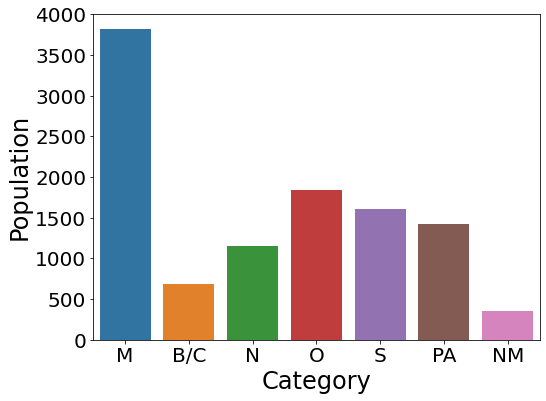

In [6]:
pretty_plot(height=6)
sns.barplot(data=pd.DataFrame(categories, index=[0]), order=['M', 'B/C', 'N', 'O', 'S', 'PA', 'NM'])
plt.xlabel('Category')
plt.ylabel('Population')

Text(0, 0.5, 'Population')

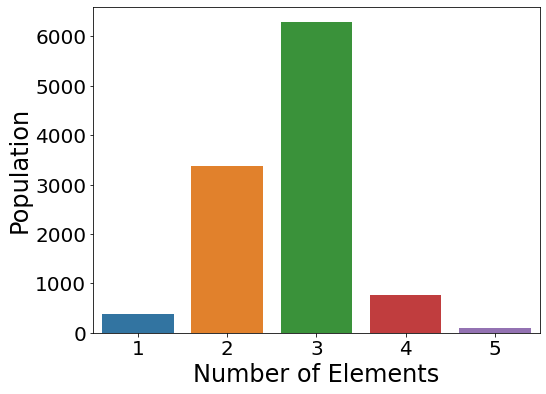

In [7]:
el_count = {cnt: np.sum(jarvis_stats['num_elements'] == cnt) for cnt in range(1,6)}
pretty_plot(height=6)
sns.barplot(data=pd.DataFrame(el_count, index=[0]))
plt.xlabel('Number of Elements')
plt.ylabel('Population')

<module 'matplotlib.pyplot' from 'c:\\Users\\hzz6536\\Anaconda3\\envs\\psed\\lib\\site-packages\\matplotlib\\pyplot.py'>

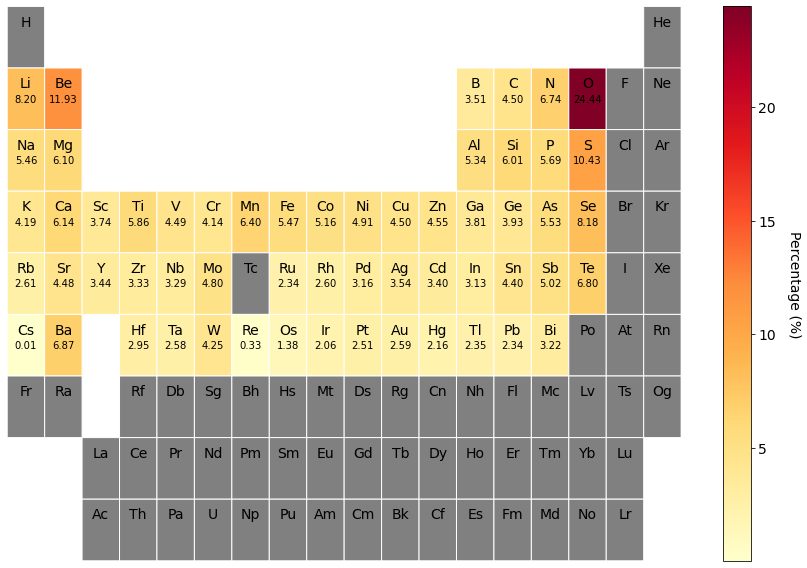

In [8]:
periodic_table_heatmap(elements, value_format='%.2f', cbar_label='Percentage (%)')